In [1]:
from google.colab import files
uploaded = files.upload()

Saving waveform_327_2047.csv to waveform_327_2047.csv


Welcome to Power Analysis Tool!

Please enter the name of the waveform file (Press <enter> to use default file): 
File chosen:  waveform_327_2047.csv
Please enter the start index (Press <enter> to use default start index): 
Start index:  327
Please enter the end index (Press <enter> to use default end index): 
End index:  2047
Please enter the max no. of traces to be use for analysis.
No. of trace will start from 10 and end at this amount in steps of 10 (Press <enter> to use all traces available in the file): 
No. of traces to use:  All

Processing  waveform_327_2047.csv ...

First 5 rows of processed data: 
    327    328    329    330    331    332    333    334    335    336   ...  \
0  0.548  0.562  0.546  0.460  0.428  0.412  0.472  0.438  0.404  0.444  ...   
1  0.392  0.496  0.400  0.490  0.474  0.410  0.432  0.440  0.400  0.428  ...   
2  0.578  0.558  0.488  0.464  0.416  0.420  0.454  0.426  0.384  0.446  ...   
3  0.574  0.550  0.466  0.484  0.448  0.406  0.470  0.448  0.412

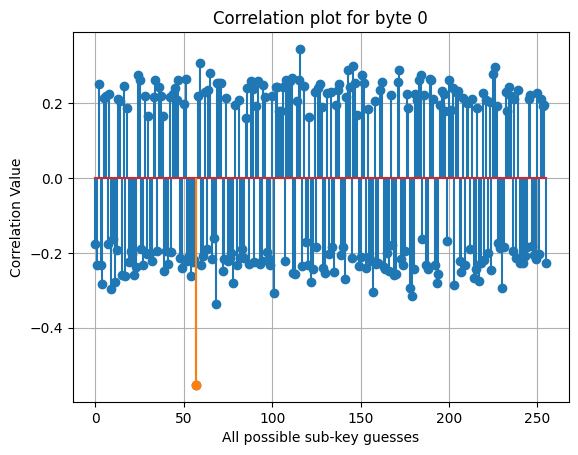

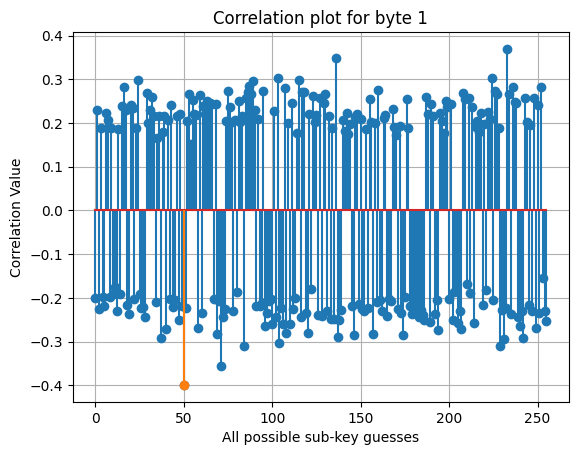

Plotting all key bytes correlation plot...


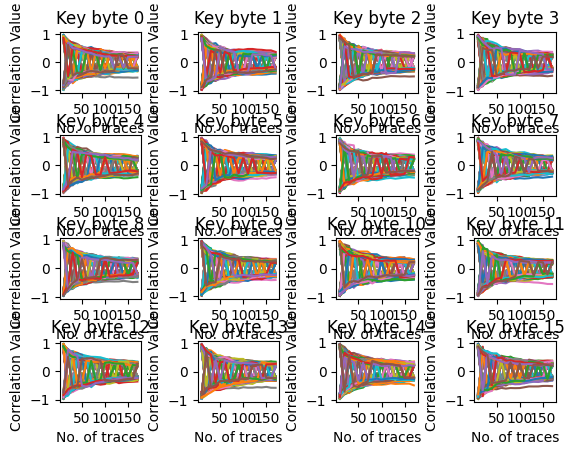

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from ToolBox import ToolBox

import sys, getopt, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from CPA import CPA


def main(argv):

    # inputfilename, startpt, endpt = getInputsArgv(argv)
    inputfilename, startpt, endpt, numTraces = getInputs()
    print("Processing ", inputfilename, "...")
    print()
    pt, ct, tracesPoints = processCSV(inputfilename, startpt, endpt)   #processes the csv input file
    if numTraces == -1:
        VisualizeTracesDifferences(pt, ct, tracesPoints)
    else:
        VisualizeTracesDifferences(pt, ct, tracesPoints[:numTraces])


def VisualizeCorrSingle(matrixRelations, byteNo):    #to visulaize the correlation

    matrixRelation = matrixRelations[byteNo]
    fig, axs = plt.subplots(1, 1)
    axs.stem(matrixRelation)
    axs.grid()
    axs.stem([abs(matrixRelation).argmax()], [matrixRelation[abs(matrixRelation).argmax()]], linefmt="C1-",
             markerfmt="C1o")

    axs.set_xlabel('All possible sub-key guesses')      # plotting  all possible subkey guesses
    axs.set_ylabel('Correlation Value')
    plt.title("Correlation plot for byte "+ str(byteNo))
    plt.show()


def VisualizeCorrAll(traceSets, matrixRelationMatList, keysize):

    # Will be size of 16
    ylistContainer = []

    for m in matrixRelationMatList:
        # ylist will have a shape of (256 by 20)
        ylist = np.concatenate(m, axis=1)
        ylistContainer.append(ylist)

    # Plotting
    numOfRowsPerFig = 4
    numOfColPerFig = 4
    numOfPlotsPerFig = numOfRowsPerFig * numOfColPerFig
    numOfFigReq = math.ceil(keysize / numOfPlotsPerFig)
    figures = np.empty(shape=numOfFigReq, dtype=object)
    figIndex = 0
    plotIndex = 1
    figures[figIndex] = plt.figure()
    figures[figIndex].subplots_adjust(hspace=0.7, wspace=0.7)

    for index, ylist in enumerate(ylistContainer):

        if plotIndex > numOfPlotsPerFig:
            figIndex += 1
            figures[figIndex] = plt.figure()
            figures[figIndex].subplots_adjust(hspace=0.9, wspace=0.9)
            plotIndex = 1
        ax = figures[figIndex].add_subplot(numOfRowsPerFig, numOfColPerFig, plotIndex)
        for y in ylist:
            ax.plot(traceSets, y)
        ax.set_title('Key byte ' + str(index))
        ax.set_xlabel('No. of traces')
        ax.set_ylabel('Correlation Value')
        plotIndex += 1

    plt.show()


def VisualizeTracesDifferences(pt, ct, tracesPoints):

    keysize = 16
    # print("Range count", (math.floor(len(tracesPoints)/10)*10)+10)
    traceSets = range(10, (math.floor(len(tracesPoints) / 10) * 10) + 10, 10)
    cpaObjs = []
    # Will contain temp 16 sets of 20 (256 by 1) matrices for concat
    matrixRelationMatList = np.empty(shape=(keysize, len(traceSets)), dtype=object)

    print("Starting CPA procedure with increasing number of traces now...")

    for index1, tracesPointsLen in enumerate(traceSets):
        print("Working with ", tracesPointsLen, " traces now...")
        cpa = CPA(keysize)
        # Set data points
        cpa.SetTracesPointsAndPT(tracesPoints[:tracesPointsLen], pt[:tracesPointsLen])
        # Do CPA
        print("Doing Correlational Power Analysis...")
        key = cpa.Analyse()
        print("Key recovered with ", tracesPointsLen, " traces is ", [hex(k) + "|" + chr(k) for k in key])
        # Size of 16
        currentMatrixRelations = cpa.GetMatrixRelations()
        # Populate matrix data for plotting later
        for index2, eachByteRelation in enumerate(currentMatrixRelations):
            # Tranpose from 1 x 256 to 256 x1
            matrixRelationMatList[index2][index1] = (np.array(eachByteRelation).reshape(len(eachByteRelation), 1))

        cpaObjs.append(cpa)

    print("Plotting single sub-key byte correlation plot...")
    VisualizeCorrSingle(cpaObjs[index1].GetMatrixRelations(), 0)
    VisualizeCorrSingle(cpaObjs[index1].GetMatrixRelations(), 1)
    print("Plotting all key bytes correlation plot...")
    VisualizeCorrAll(traceSets, matrixRelationMatList, keysize)


def getInputs():
    defaultCSV = "waveform_327_2047.csv"
    defaultStart = 327
    defaultEnd = 2047
    defaultNumTraces = -1

    print("Welcome to Power Analysis Tool!")
    print("===============================")
    print()
    inputfilename = input(
        "Please enter the name of the waveform file (Press <enter> to use default file): ") or defaultCSV
    print("File chosen: ", inputfilename)
    startpt = int(input("Please enter the start index (Press <enter> to use default start index): ") or defaultStart)
    print("Start index: ", startpt)
    endpt = int(input("Please enter the end index (Press <enter> to use default end index): ") or defaultEnd)
    print("End index: ", endpt)
    numTraces = int(input(
        "Please enter the max no. of traces to be use for analysis.\nNo. of trace will start from 10 and end at this amount in steps of 10 (Press <enter> to use all traces available in the file): ") or defaultNumTraces)
    print("No. of traces to use: ", numTraces if numTraces != -1 else 'All')
    print()

    return inputfilename, startpt, endpt, numTraces


def getInputsArgv(argv):
    if len(argv) < 3 and not ("-h" in argv):
        print("Wrong command format!")
        print("Please supply csv file and options. Use -h option for example command.")
        sys.exit(2)
    try:
        opts, args = getopt.getopt(argv, "hi:s:e:", ["ifile=", "startpt=", "endpt="])
    except getopt.GetoptError:
        print("Wrong command format!")
        print("Use -h option for example command")
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print("eg: Main.py -i waveform.csv -s 327 -e 2046 ")
            sys.exit(2)
        elif opt in ("-i", "--ifile"):
            inputfilename = arg
        elif opt in ("-s", "--startpt"):
            startpt = arg
        elif opt in ("-e", "--endpt"):
            endpt = arg
    print("Input file is ", inputfilename)

    return inputfilename, int(startpt), int(endpt)


def processCSV(filename, startpt, endpt):
    # index start at 0 conversion
    startpt -= 1
    endpt -= 1

    dframe = pd.read_csv(filename, header=None)
    dframe = dframe.dropna(axis=1, how='any')  # Cleanup data: Removes anything that's not a number
    pt = dframe.iloc[:, 0:1]
    ct = dframe.iloc[:, 1:2]
    dataTraces = dframe.iloc[:, startpt + 1:endpt]
    print("First 5 rows of processed data: ")
    print(dataTraces.head())
    print()

    return pt.values, ct.values, dataTraces.values



class ToolBox():               #  for s box transformations

    sboxTable = (
        0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
        0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
        0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
        0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
        0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
        0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
        0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
        0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
        0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
        0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
        0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
        0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
        0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
        0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
        0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
        0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    )


    def __init__(self):
        pass

    def Sbox(self, inp):
        return self.sboxTable[inp]
        pass

    def HammingWeight(self, num, ret=0):

        count = 0

        while num >= 1:

            if num%2 > 0:
                count+=1
            num /= 2

        if ret == 0:
            return 6 - count
        else:
            return count

    def HammingDistance(self, num1, num2):

        return self.HammingWeight(num1^num2)
class CPA():

    toolbox = ToolBox()

    def __init__(self, keySize=16):
        self.traceSetCount = 0
        self.key = []
        self.keySize = keySize
        self.hypothesis = None
        self.plainTexts = None
        self.tracesPoints = None
        self.matrixRelation = None
        self.matrixRelations = []


    def SetTracesPointsAndPT(self, tracesPoints, plainTexts):

        self.tracesPoints = tracesPoints
        self.plainTexts = plainTexts

    def GetKey(self):
        return self.key

    def Analyse(self):

        for i in range(1, self.keySize + 1, 1):

            self.InitHypothesis(i)

            # Shape of hypothesis: (373, 256)
            # Shape of tracesPoints: (373, 1719)
            # Shape of corrMatrix: (256, 1719)
            corrMatrix = self.Correlate(self.hypothesis, self.tracesPoints)

            matrixRelation = np.zeros(256)
            # Get max correlation value from among the traces data points
            for j in range(256):

                # Get max value in abs form but preserve the sign
                matrixRelation[j] = corrMatrix[j][abs(corrMatrix[j]).argmax()]

            # Get index of highest correlation value out of the 256 permutations
            index = abs(matrixRelation).argmax()

            # Store subkey i guesses matrix for visualization purposes
            self.matrixRelation = matrixRelation
            self.matrixRelations.append(matrixRelation)

            self.key.append(index)

        return self.key

    def Correlate(self, A, B):

        # Transpose data
        A = A.T
        B = B.T

        # print("Shape of A: ", A.shape)
        # print("Shape of B: ", B.shape)

        # Row-wise mean of input arrays & subtract from input arrays themselves
        # Mean normalization
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA ** 2).sum(1)
        ssB = (B_mB ** 2).sum(1)

        # Finally get corr coeff
        return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))

    def InitHypothesis(self, byteNumber):

        # Initialise data structure
        keyHyp = [i for i in range(256)]
        self.hypothesis = np.zeros((len(self.plainTexts), len(keyHyp)))

        # Loop through all the traces
        for i in range(len(self.plainTexts)):

            # Get the current plain text byte via array slicing
            # Note that array is 3 dimensional due to conversion from Pandas frame
            # to Numpy array
            subPT = self.plainTexts[i][0][2 * (byteNumber - 1):2 * byteNumber]

            # Construct hypothetical data for each key-byte guesses
            for j in range(len(keyHyp)):
                # Do sbox transformation according to look-up table
                sboxResult = self.toolbox.Sbox(int(subPT, 16) ^ keyHyp[j])
                # Estimate hypothetical power consumption value as hamming weights
                self.hypothesis[i][j] = self.toolbox.HammingWeight(sboxResult)

    def GetMatrixRelations(self):

        return self.matrixRelations

    def VisualizeCorrSingle(self, matrixRelation, index):    # correlation between traces,potential guesses

        fig, axs = plt.subplots(1, 1)
        axs.stem(matrixRelation)
        axs.grid()
        # axs.stem(index, matrixRelation[index])
        axs.stem([index], [matrixRelation[index]], linefmt="C1-", markerfmt="C1o")

        plt.show()

    def VisualizeCorrAll(self, matrixRelation, index):

        currentByte = self.CorrBytes[0]
        fig, axs = plt.subplots(1, 1)
        axs.plot(matrixRelation)
        axs.grid()

        plt.show()

if __name__ == "__main__":
    main(sys.argv[1:])